[Pyspark blog](https://bryancutler.github.io/)

[ML w/ Pyspark](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

[GitHub event types](https://developer.github.com/v3/activity/events/types/)

[Churn modeling](https://www.urbanairship.com/blog/churn-prediction-our-machine-learning-model)

[Interpreting Trees](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)

[Intro to Boosted Trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html#why-introduce-the-general-principle)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Binarizer#, OneHotEncoderEstimator, StringIndexer
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import helper as h

In [2]:
_data = h.get_merged_data('classification')
cols = _data.columns

_data.head()

% of users dropped 4.698526359485271


Row(login='0loky0', followers_count=0, following_count=1, blog=0, company=0, created_at='2011-05-24 20:15:25+00:00', public_repos_count=7, public_gists_count=0, hireable=1, updated_at='2019-01-09 15:03:59+00:00', time_between_first_last_event='10 days 15:29:06.000000000', last_event='2016-04-15 10:14:03 UTC', first_event='2016-04-04 18:44:57 UTC', frequency=19, second_period_event_count=0, CommitCommentEvent_count=0, CreateEvent_count=5, DeleteEvent_count=0, ForkEvent_count=2, GollumEvent_count=0, IssueCommentEvent_count=0, IssuesEvent_count=0, MemberEvent_count=0, PublicEvent_count=0, PullRequestEvent_count=0, PullRequestReviewCommentEvent_count=0, PushEvent_count=12, ReleaseEvent_count=0, WatchEvent_count=0)

In [3]:
#scaled_data = h.feature_scaling(_data)
#scaled_data.head()

In [4]:
model_name = 'high_frequency'
churn_data = _data.filter((_data.company == 0) & (_data.frequency > 10)) 

In [5]:
numeric_features = [t[0] for t in churn_data.dtypes if t[1] == 'int' or t[1] == 'double']
churn_data.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
followers_count,60613,4.805140811377098,29.81502995671684,0,2491
following_count,60613,5.06660287397093,76.12389262932119,0,17459
blog,60613,0.14760859881543564,0.3547144995664883,0,1
company,60613,0.0,0.0,0,0
public_repos_count,60601,15.07476774310655,34.15604509150617,0,1675
public_gists_count,60612,1.5527123341912492,8.243314232201483,0,539
hireable,60613,0.11136224902248693,0.31458278911387105,0,1
frequency,60613,40.41939847887417,36.01336246413108,11,199
second_period_event_count,60613,22.147344629039974,35.06564656207987,0,199


In [6]:
numeric_features.remove('second_period_event_count')
numeric_features.remove('frequency')
print(numeric_features)

['followers_count', 'following_count', 'blog', 'company', 'public_repos_count', 'public_gists_count', 'hireable', 'CommitCommentEvent_count', 'CreateEvent_count', 'DeleteEvent_count', 'ForkEvent_count', 'GollumEvent_count', 'IssueCommentEvent_count', 'IssuesEvent_count', 'MemberEvent_count', 'PublicEvent_count', 'PullRequestEvent_count', 'PullRequestReviewCommentEvent_count', 'PushEvent_count', 'ReleaseEvent_count', 'WatchEvent_count']


## Build PySpark pipeline

In [7]:
stages = []
# binarizer needs double type or it throws an error.
churn_data = churn_data.withColumn("second_period_event_count", 
                                   churn_data.second_period_event_count.cast(DoubleType()))
binarizer = Binarizer(threshold=0.5, 
                      inputCol="second_period_event_count", 
                      outputCol="label")

stages += [binarizer]
assembler = VectorAssembler(inputCols=numeric_features, 
                            outputCol="features").setHandleInvalid("skip")
stages += [assembler]

In [8]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(churn_data)
churn_data = pipelineModel.transform(churn_data)
selectedCols = ['label', 'features'] + cols
churn_data = churn_data.select(selectedCols)
churn_data.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- login: string (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- following_count: integer (nullable = true)
 |-- blog: integer (nullable = true)
 |-- company: integer (nullable = true)
 |-- created_at: string (nullable = true)
 |-- public_repos_count: integer (nullable = true)
 |-- public_gists_count: integer (nullable = true)
 |-- hireable: integer (nullable = true)
 |-- updated_at: string (nullable = true)
 |-- time_between_first_last_event: string (nullable = true)
 |-- last_event: string (nullable = true)
 |-- first_event: string (nullable = true)
 |-- frequency: integer (nullable = true)
 |-- second_period_event_count: double (nullable = true)
 |-- CommitCommentEvent_count: integer (nullable = true)
 |-- CreateEvent_count: integer (nullable = true)
 |-- DeleteEvent_count: integer (nullable = true)
 |-- ForkEvent_count: integer (nullable = true)
 |-- GollumEvent_count: integer

In [9]:
# save pipeline
pipeline.write().overwrite().save('pipeline')

In [10]:
examples = pd.DataFrame(churn_data.take(5), columns=churn_data.columns).transpose()
examples

,0,1,2,3,4
label,0,1,0,0,0
features,"(0.0, 1.0, 0.0, 0.0, 7.0, 0.0, 1.0, 0.0, 5.0, ...","(2.0, 6.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0,...","(1.0, 28.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ..."
login,0loky0,2582056905xy,277542952,5152683,5152683
followers_count,0,2,1,0,0
following_count,1,6,28,0,0
blog,0,0,0,0,0
company,0,0,0,0,0
created_at,2011-05-24 20:15:25+00:00,2014-04-24 14:51:26+00:00,2016-03-16 03:17:58+00:00,2016-03-08 09:49:22+00:00,2016-03-08 09:49:22+00:00
public_repos_count,7,35,1,0,0
public_gists_count,0,0,0,0,0


### Training/Test split

In [11]:
train, test = churn_data.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: {0}".format(train.count()))
print("Test Dataset Count: {0}".format(test.count()))

Training Dataset Count: 42278
Test Dataset Count: 18323


## Logistic Regression

In [30]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=20,
                        #regParam=0.3, elasticNetParam=0.08
                       )
lrModel = lr.fit(train)

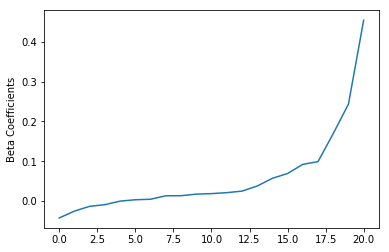

array([ 0.0212489 ,  0.01749635,  0.45402465,  0.        ,  0.06930232,
        0.02504234,  0.24335528,  0.01341857, -0.00888737,  0.01881407,
       -0.04217852,  0.0034249 ,  0.0572392 ,  0.00469357, -0.02504956,
        0.16951134, -0.01302546,  0.03776817,  0.01353915,  0.09229007,
        0.09905671])

In [33]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [34]:
pd.DataFrame({'features': numeric_features, # np.asarray(numeric_features)[lrModel.coefficients.indices], 
              'weights': lrModel.coefficients.values}
            ).sort_values(by='weights', ascending=False)


,features,weights
2,blog,0.454025
6,hireable,0.243355
15,PublicEvent_count,0.169511
20,WatchEvent_count,0.099057
19,ReleaseEvent_count,0.092290
4,public_repos_count,0.069302
12,IssueCommentEvent_count,0.057239
17,PullRequestReviewCommentEvent_count,0.037768
5,public_gists_count,0.025042
0,followers_count,0.021249


Training set areaUnderROC: 0.7994581198492993


/home/brian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


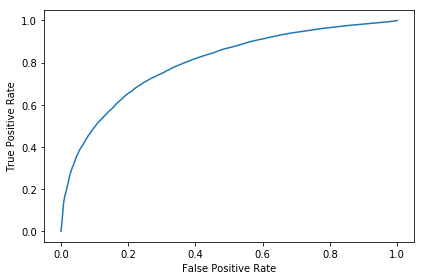

In [35]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()

fig, ax = plt.subplots(1,1)
fig.set_tight_layout(True)

ax.plot(roc['FPR'],roc['TPR'])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
#ax.title('ROC Curve')
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


fig.savefig('figures/logistic_regression_ROC.png')

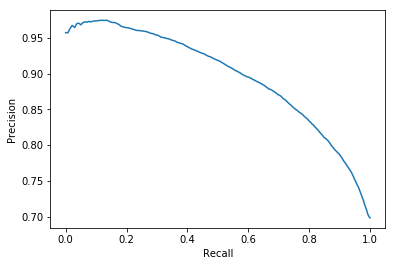

In [36]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [37]:
#lrModel._java_obj.setThreshold(0.75)
print('Threshold: {0}'.format(lrModel._java_obj.getThreshold()))
predictions = lrModel.transform(test)
show_cols = ['followers_count', 'company', 'blog', 
             'label', 'rawPrediction', 'prediction', 'probability']
predictions.select(show_cols).show(10)

Threshold: 0.5
+---------------+-------+----+-----+--------------------+----------+--------------------+
|followers_count|company|blog|label|       rawPrediction|prediction|         probability|
+---------------+-------+----+-----+--------------------+----------+--------------------+
|              4|      0|   1|  0.0|[-0.6696111556130...|       1.0|[0.33858391502762...|
|             10|      0|   0|  0.0|[-2.2993799954200...|       1.0|[0.09117432254449...|
|              1|      0|   0|  0.0|[-0.8675358321534...|       1.0|[0.29576730263748...|
|              1|      0|   0|  0.0|[-1.3079963283786...|       1.0|[0.21282232403973...|
|              4|      0|   1|  0.0|[-1.0858982828231...|       1.0|[0.25239144509379...|
|              1|      0|   0|  0.0|[0.04835870964598...|       0.0|[0.51208732192117...|
|              3|      0|   0|  0.0|[-0.4192345111929...|       1.0|[0.39669993938595...|
|              0|      0|   0|  0.0|[-0.2817126966990...|       1.0|[0.43003393575767

In [38]:
h.eval_metrics(predictions)

Precision: 0.792
Recall:    0.898
Accuracy:  0.763
F1-score:  0.8421


In [ ]:
lrModel.write().overwrite().save('lrModel_' + model_name)

## Gradient Boosted Trees

[Gradient Boost vs XGboost](https://datascience.stackexchange.com/questions/16904/gbm-vs-xgboost-key-differences)

In [ ]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
h.write_tree_to_file(gbtModel.toDebugString, 'gbt_trees_' + model_name)
predictions = gbtModel.transform(test)
predictions.select(show_cols).show(10)

In [ ]:
h.eval_metrics(predictions)

#### Feature importances
[pyspark feature imortances doc] (http://spark.apache.org/docs/2.1.1/api/python/pyspark.ml.html#pyspark.ml.classification.GBTClassificationModel.featureImportances):

Estimate of the importance of each feature.

Each feature’s importance is the average of its importance across all trees in the ensemble The importance vector is normalized to sum to 1. This method is suggested by Hastie et al. (Hastie, Tibshirani, Friedman. “The Elements of Statistical Learning, 2nd Edition.” 2001.) and follows the implementation from scikit-learn.

In [ ]:
print(gbtModel.featureImportances.indices)
numeric_features = np.asarray(numeric_features)
pd.DataFrame([numeric_features[gbtModel.featureImportances.indices], 
              gbtModel.featureImportances.values]).T.sort_values(by=[1], ascending=False)

In [ ]:
'''evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(
    evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))'''

## Random forest classification

In [20]:
'''rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
h.write_tree_to_file(rfModel.toDebugString, 'rf_trees_' + model_name)
predictions = rfModel.transform(test)
predictions.select(show_cols).show(10)
h.eval_metrics(predictions)'''

## Grid search with cross validation

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)